# Wetland pixel visualisation <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` environment
* **Products used:** 
[fc_percentile_albers_annual](https://explorer.sandbox.dea.ga.gov.au/fc_percentile_albers_annual)

## Background
We're trying to identify wetlands en masse in Australia from earth observation imagery. Our current best approach to doing this is to implement two thresholds based on tasseled cap wetness and greenness, but this picks up forest and cropland as wetlands.

## Description

To help identify where we might be able to screen out non-wetlands, this notebook generates visualisations of raster properties in wetland regions in Queensland (QLD). QLD has extremely detailed [wetland mapping](https://wetlandinfo.des.qld.gov.au/wetlandmaps/) and we can use their information to help understand what bulk properties wetlands have.

## Getting started

Run all cells in this notebook to generate the histograms as well as a test sample of wetland pixels. There are some toggles in the data loading to cache and restore sampled data on second runs of the notebook, which greatly improves speed on later runs. 

### Load packages
Import Python packages that are used for the analysis.

In [2]:
%matplotlib inline

import functools
from multiprocessing.pool import Pool
import multiprocessing
import os
import sys
import datacube
from datacube.storage.masking import make_mask
import datacube.utils.cog
import datacube.utils.geometry
import geopandas as gpd
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.colors
import matplotlib.patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import odc.ui
from odc.ui import with_ui_cbk
import rasterio.features
import rasterio.mask
import scipy.stats
import seaborn
from shapely.geometry import shape
from shapely.validation import explain_validity
import skimage.color as colour
import skimage.io
import sklearn.metrics
from tqdm.notebook import tqdm
import xarray

sys.path.append("../Scripts")
from dea_plotting import rgb

/g/data/v10/public/modules/dea/20200617/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="wetland-histograms")

### Load wetland shapes

The wetlands shapefile contains wetlands in VIC.

In [4]:
wetlands = gpd.read_file(
    "vic_wetland.shp"
)

In [10]:
wetlands.AQ_SYS.unique()

array(['Palustrine', 'Lacustrine',
       'Palustrine or Lacustrine (unknown specifics)', 'Estuarine',
       'Marine'], dtype=object)

The wetlands are partly invalid geometry due to self-intersection, so we make a best-attempt at fixing them.

In [11]:
validity = wetlands.geometry.apply(
    lambda k: explain_validity(k) if k is not None else None
)

In [12]:
invalid = validity != "Valid Geometry"

In [13]:
# Fix invalid geometries.
fixed_wetlands = wetlands[invalid].geometry.buffer(0)
wetlands_original = wetlands
wetlands = wetlands.copy()
wetlands.loc[invalid, "geometry"] = fixed_wetlands

## Sample from wetlands and non-wetlands

The tiles are way too big to fit them all into memory, but data in memory will be much faster to plot and generate statistics on. We can take a sample of wetland and non-wetland pixels. How many wetland and non-wetland pixels do we have?

In [18]:
sampled_wetland_area = wetlands.to_crs('EPSG:3577').area.sum()
sampled_wetland_area * 1e-6  # m^2 -> km^2

7840.924794222047

How big is each pixel? If we read in (generously) 20 bands of information, each band stored as a 64-bit (= 8 bytes) float, then each pixel needs 160 bytes to store in memory. Each pixel is 625 m$^2$, so we have

In [19]:
n_wetland_pixels = sampled_wetland_area / 625
n_wetland_pixels * 160 * 1e-9

2.0072767473208444

about 2 GB of memory needed to store everything. We can sample either the same amount of non-wetland pixels (for class balancing) or the same fraction of non-wetland pixels.

The following functions load data:

In [52]:
def get_fc(da):
    fc = dc.load(
        "fc_percentile_albers_annual",
        **{
            "time": "2019",
            "geopolygon": datacube.utils.geometry.Geometry(da.geobox.extent),
        }
    )
    return fc

In [57]:
def get_tcw(tile_label):
    tif_path_base = "/g/data/r78/datacube_stats/ls_tcw_percentiles/tcw_percentiles_cog/LS_TCW_PC_{}_19870101_20181025_TCW_PC_90.tif"
    tif_path = tif_path_base.format(tile_label.replace(",", "_"))
    da = xarray.open_rasterio(tif_path)
    return da


def make_wetland_mask(da):
    raster_wetland = rasterio.features.rasterize(
        shapes=wetlands.buffer(0),
        out_shape=da.y.shape + da.x.shape,
        all_touched=False,
        default_value=1,
        fill=0,
        transform=da.geobox.transform,
    )
    return raster_wetland.astype(bool)


def make_wetland_raster(da):
    rasters = []
    for i, wetland_class in enumerate(sorted(wetlands.AQ_SYS.unique())):
        raster_wetland = rasterio.features.rasterize(
            shapes=wetlands.to_crs('EPSG:3577')[wetlands.AQ_SYS == wetland_class].buffer(0),
            out_shape=da.y.shape + da.x.shape,
            all_touched=False,
            default_value=i + 1,
            fill=0,
            transform=da.geobox.transform,
        )
        rasters.append(raster_wetland)
    assert (np.product(rasters, axis=0) == 0).all()
    return np.sum(rasters, axis=0)


def get_mrvbf(tile_label):
    mrvbf_path_base = (
        mrvbf_base_path
    ) = "/g/data/u46/wofs/confidence_albers/MrVBF/tiles/mrvbf_{}.nc"
    mrvbf_path = mrvbf_path_base.format(tile_label.replace(",", "_"))
    da = xarray.open_dataset(mrvbf_path)
    return da


def get_koppen_tile(da):
    koppen = rasterio.open(
        "/g/data/r78/ma6611/Beck_KG_V1_present_0p0083.tif"
    )  # 1km resolution
    dest = np.zeros(da.shape)
    src_transform = koppen.transform
    koppen_tile = rasterio.warp.reproject(
        koppen.read(),
        dest,
        src_crs=koppen.crs,
        dst_crs="EPSG:3577",
        src_transform=src_transform,
        dst_transform=da.transform,
    )
    return koppen_tile[0].astype(int)

Run the following cells to generate new wetlands samples, or load an existing NetCDF file. Set `class_balance` to `True` if you want the same number of wetland and non-wetland pixels, or `False` to get a sample that matches the real distribution. Set `sample_rate` to the rate that you want wetlands sampled at: we recommend 5% for class imbalance and 25% for class balance.

In [42]:
class_balance = False
sample_rate = 0.05

In [43]:
if not class_balance:
    wetland_sample_rate = nonwetland_sample_rate = sample_rate
else:
    wetland_sample_rate = sample_rate
    nonwetland_sample_rate = nonwetland_sample_rate_ * 4 * sample_rate

print(f"Wetland sample rate: {wetland_sample_rate:.02%}")
print(f"Non-wetland sample rate: {nonwetland_sample_rate:.02%}")

Wetland sample rate: 5.00%
Non-wetland sample rate: 5.00%


The following code generates the random sample of pixels and saves them to `wetland_data_sample_unbalanced_vic.nc`. Set `load_saved` to `True` to instead load this file.

In [81]:
tiles = ['15,-42', '10,-40', '11,-41']

In [82]:
load_saved = False

In [83]:
if not load_saved:
    features = {
        "TCW": [],
        "MrVBF": [],
        "Wetland": [],
        "x": [],
        "y": [],
        "Koppen": [],
        "PV90": [],
        "PV50": [],
        "PV10": [],
    }

    np.random.seed(1)
    for i, tile in tqdm(enumerate(tiles)):
        label = tile
        tcw = get_tcw(label)
        fc = get_fc(tcw.isel(band=0))
        mrvbf = get_mrvbf(label).band1.isel(time=0)
        koppen = get_koppen_tile(tcw.isel(band=0))
        wet = make_wetland_raster(tcw.isel(band=0))
        mask = np.zeros(wet.shape, dtype=bool)
        mask[wet > 0] = np.random.binomial(1, wetland_sample_rate, size=(wet > 0).sum())
        mask[wet == 0] = np.random.binomial(
            1, nonwetland_sample_rate, size=(wet == 0).sum()
        )

        features["TCW"].append(tcw.isel(band=0).values[mask])
        x, y = np.meshgrid(tcw.x, tcw.y)
        features["x"].append(x[mask])
        features["y"].append(y[mask])
        features["Wetland"].append(wet[mask])
        features["Koppen"].append(koppen[mask])
        features["MrVBF"].append(mrvbf.values[mask])

        features["PV90"].append(fc.PV_PC_90.isel(time=0).values[mask])
        features["PV50"].append(fc.PV_PC_50.isel(time=0).values[mask])
        features["PV10"].append(fc.PV_PC_10.isel(time=0).values[mask])

    features_ = {}
    for k, f in features.items():
        if len(f[0].shape) == 1:
            features_[k] = np.concatenate([a.reshape(1, -1) for a in f], axis=1)
        else:
            features_[k] = np.concatenate(f, axis=1)

    features, features_ = features_, features

    tile = []
    for i, a in enumerate(features_["x"]):
        tile.extend([i] * len(a))

    df = gpd.pd.DataFrame(
        {
            "TCW90": features["TCW"][0],
            "MrVBF": features["MrVBF"][0],
            "Koppen": features["Koppen"][0],
            "Wetland": features["Wetland"][0],
            "x": features["x"][0],
            "y": features["y"][0],
            "tile": tile,
            "PV90": features["PV90"][0],
            "PV50": features["PV50"][0],
            "PV10": features["PV10"][0],
        }
    )
    df.to_xarray().to_netcdf("wetland_data_sample_unbalanced_vic.nc")
else:
    df = xarray.open_dataset("wetland_data_sample_unbalanced_vic.nc").to_dataframe()

Note that we can recover an approximation of a tile by using the x and y values. Here is a function to help do that:

In [63]:
def spatial_plot_tile(tile, column, **kwargs):
    mask = df.tile == tile
    if isinstance(column, str):
        c = df[column][mask]
    else:
        c = column[mask]
    plt.scatter(df.x[mask], df.y[mask], c=c, edgecolor="None", s=2, **kwargs)

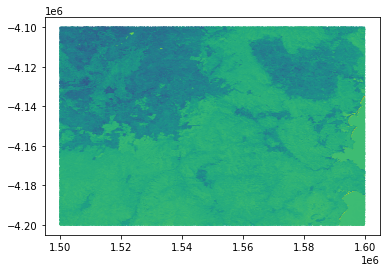

In [65]:
spatial_plot_tile(0, df.TCW90)

## Plotting histograms

Let's look at the distribution of TCW 90, PV50, and PV50 - PV10 for wetlands and non-wetlands.

In [84]:
wetland_class_names = ['Non-wetland'] + sorted(wetlands.AQ_SYS.unique())

In [85]:
wetland_column = df.Wetland > 0
wetland_class = df.Wetland.map(
    wetland_class_names.__getitem__
)

In [86]:
wetland_class.name = "Wetland Class"

In [87]:
features = gpd.pd.concat(
    [df.TCW90, df.PV50, df.PV50 - df.PV10, wetland_column, wetland_class], axis=1
).rename(columns={0: "PV50 - PV10"})

Let's see how these features behave for wetland and non-wetland pixels.

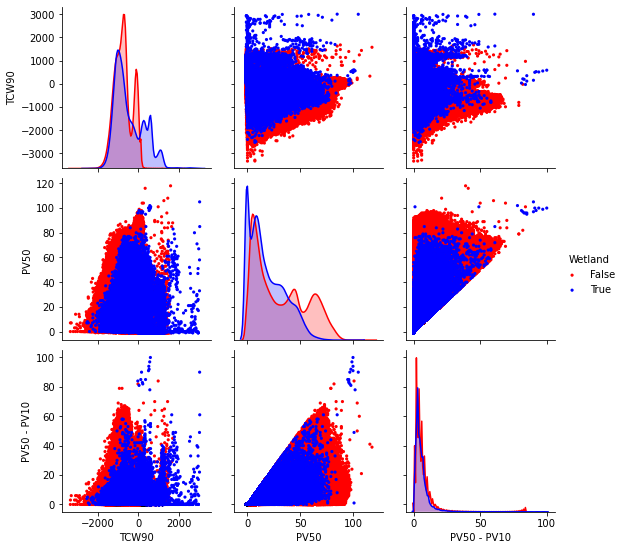

In [88]:
pp = seaborn.pairplot(
    features,
    hue="Wetland",
    plot_kws={"s": 10, "edgecolor": "None"},
    palette=["red", "blue"],
)
# pp.axes[0, 0].axvline(-600, color='grey', linestyle='--')

From these histograms we can tell that there won't be a "magic bullet" where we can easily divide a feature into two to separate wetlands. Any division will need to be a function of multiple features.

We could also separate these plots by wetland type:

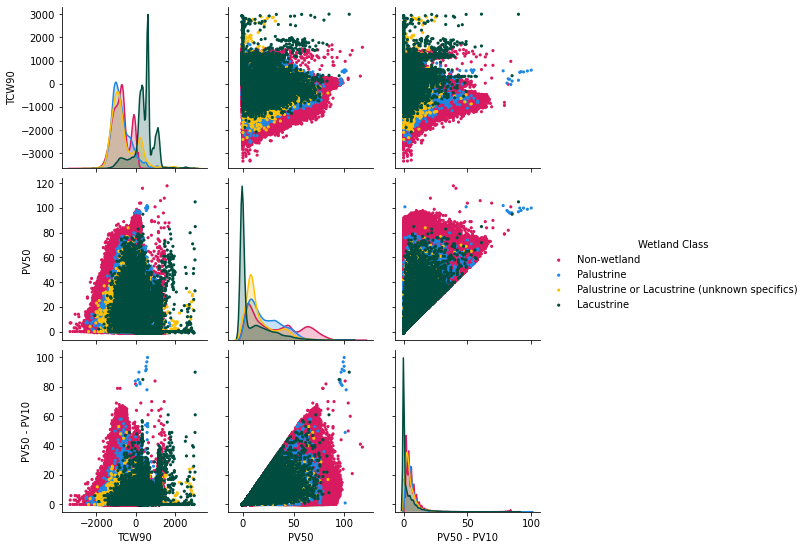

In [90]:
# ['Non-wetland', 'Estuarine', 'Lacustrine', 'Marine', 'Palustrine', 'Riverine']
# Colourblind-friendly for all three main types of colourblindness:
palette = ['#D81B60', '#1E88E5', '#FFC107', '#004D40', '#421677', '#808080']
pp = seaborn.pairplot(
    features.drop("Wetland", axis=1),
    hue="Wetland Class",
    plot_kws={"s": 10, "edgecolor": "None"},
    palette=palette,
)

## Behaviour of thresholds

We currently have a wetland classifier that follows the following decision tree:

```
TCW 95 > -600?
    Yes: MrVBF >= 3?
        Yes: TCG 50 < 1400?
            Yes: Wetland.
            No: Not wetland.
        No: TCG 50 < 1000:
            Yes: Wetland.
            No: Not wetland.
    No: Not wetland.
```

Let's see how it behaves on a tile.

In [92]:
decision = (df.TCW90 > -600) & (df.PV50 < 75)

In [93]:
def plot_tile_classifications(tile_index):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    spatial_plot_tile(tile_index, np.where(decision, 1, np.nan), cmap='summer')
    plt.subplot(1, 2, 2)
    spatial_plot_tile(tile_index, np.where(df.Wetland, df.Wetland, np.nan), cmap=matplotlib.colors.ListedColormap(palette),
                      norm=matplotlib.colors.BoundaryNorm(range(7), len(palette)))
    plt.legend([matplotlib.patches.Patch(facecolor=c) for c in palette],
               wetland_class_names, loc='lower right')

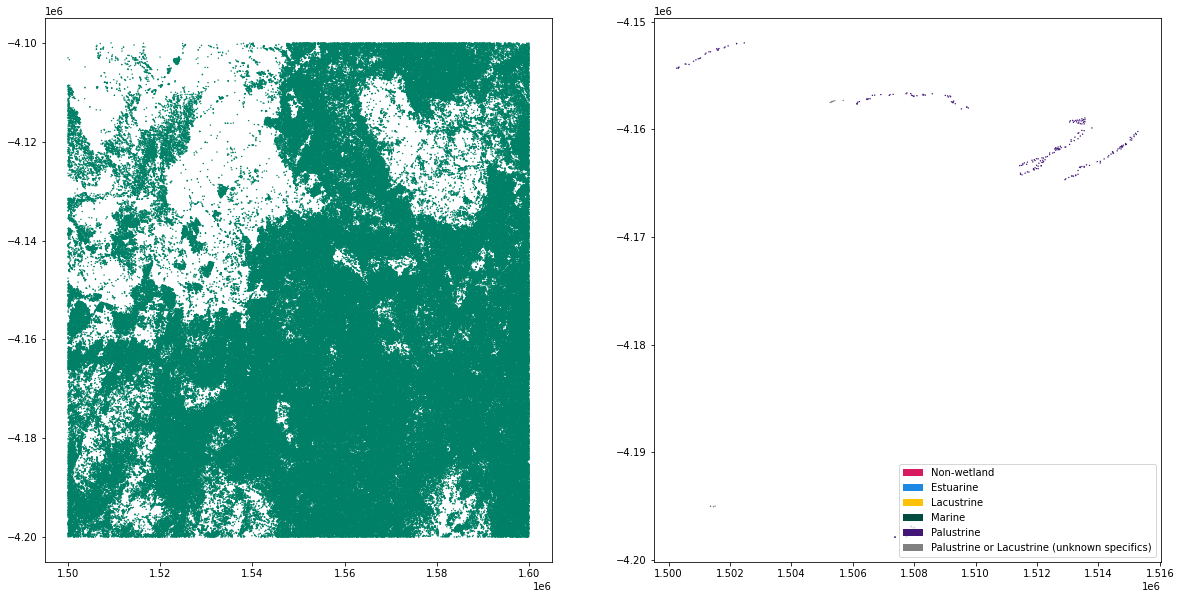

In [95]:
plot_tile_classifications(0)

## The effect of MrVBF

MrVBF already seems to have a lot of wetland information in it. Let's look at MrVBF vs TCW 95 and TCG 50.

In [360]:
def plot_mrvbf_df(df, wetland_colour=None, violin=False):
    if wetland_colour is None:
        wetland_colour = 'blue'
    nonwetland_colour = palette[0]

    blue = matplotlib.patches.Patch(facecolor=wetland_colour)
    red = matplotlib.patches.Patch(facecolor=nonwetland_colour)

    cmap = matplotlib.colors.ListedColormap([nonwetland_colour, wetland_colour])

    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    if not violin:
        offset = np.where(df.Wetland > 0, 1, -1) * np.abs(
            np.random.normal(scale=0.1, size=len(df))
        )
        plt.scatter(
            df.MrVBF + offset, df.TCW95, c=df.Wetland > 0, cmap=cmap, s=1, alpha=0.1
        )
    else:
        violinparams = dict(hue_order=[False, True], palette=[nonwetland_colour, wetland_colour], split=True,
                           linewidth=0, saturation=1, inner=None, cut=0, bw=0.1)
        seaborn.violinplot(x=df.MrVBF, y=df.TCW95, hue=df.Wetland > 0, **violinparams)
    
    plt.xlabel("MrVBF")
    plt.ylabel("TCW 95")
    plt.axhline(-600, color="grey", linestyle="--")
    plt.legend([blue, red], ["wetland", "non-wetland"], loc="upper left")

    plt.subplot(1, 3, 2)
    if not violin:
        plt.scatter(
            df.MrVBF + offset, df.TCG50, c=df.Wetland > 0, cmap=cmap, s=1, alpha=0.1
        )
    else:
        seaborn.violinplot(x=df.MrVBF, y=df.TCG50, hue=df.Wetland > 0, **violinparams)
    plt.xlabel("MrVBF")
    plt.ylabel("TCG 50")

    plt.plot([-1, 2.5], [1000, 1000], color="grey", linestyle="--")
    plt.plot([2.5, 10], [1400, 1400], color="grey", linestyle="--")
    plt.legend([blue, red], ["wetland", "non-wetland"], loc="upper left")

    return fig

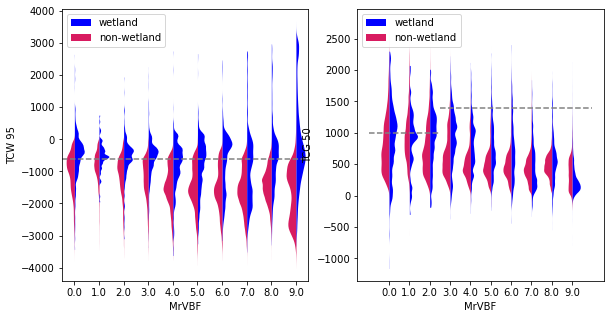

In [361]:
plot_mrvbf_df(df[::100], wetland_colour='blue', violin=True);

How does this change with different classes of wetland?

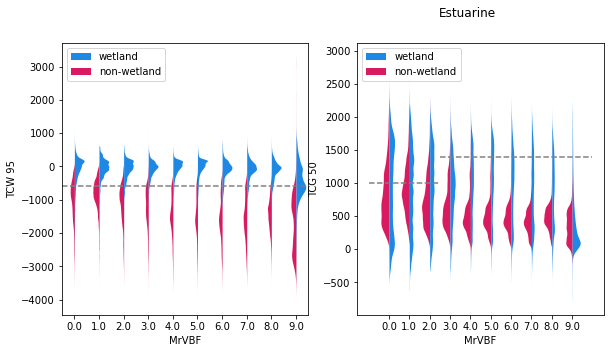

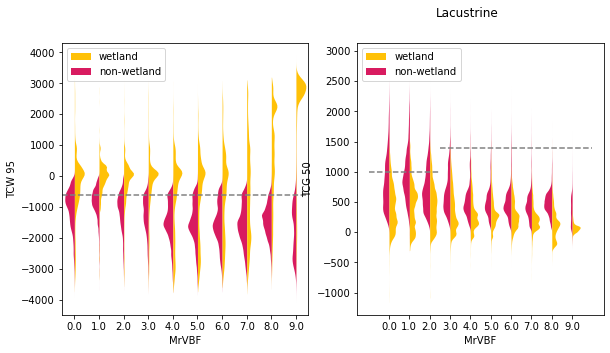

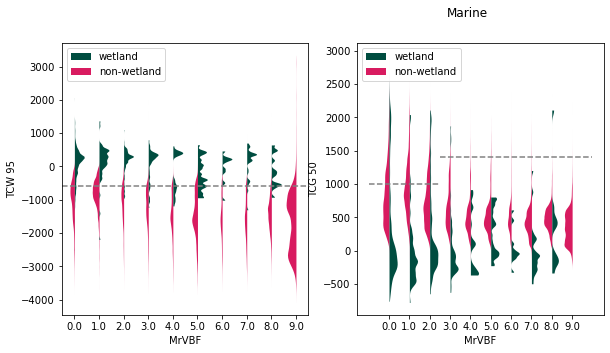

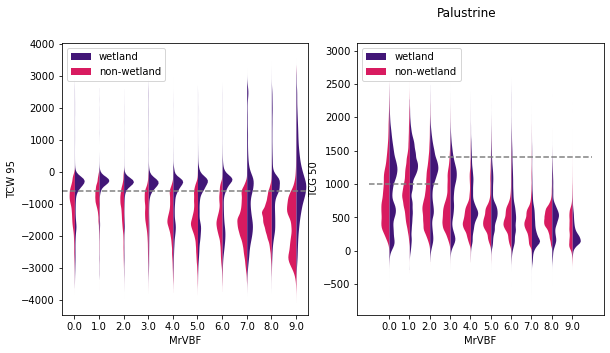

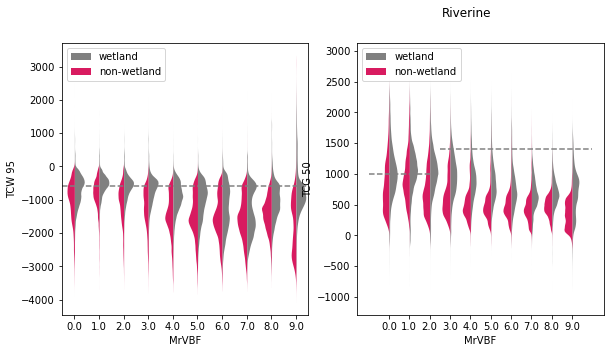

In [362]:
for wetland_index in range(1, 6):
    df_ = gpd.pd.concat([df[df.Wetland == 0][::100], df[df.Wetland == wetland_index]], axis=0)
    plot_mrvbf_df(df_, wetland_colour=palette[wetland_index], violin=True)
    plt.suptitle(wetland_class_names[wetland_index])
    plt.show()

## Climate zones

Maybe the appearance of wetlands varies by climate zone? Let's repeat the previous plots, but subdivide by Koppen climate zone.

This is a great way to split out wetlands, but we also need something to distil the confusion at high values of MrVBF. But let's drill down even further. What are we actually confusing here?

In [166]:
koppen_zones = sorted(
    set(df.Koppen.unique())
) 
len(koppen_zones)

10

In [168]:
koppen_titles = [
    "Ocean",
    "Af",
    "Am",
    "Aw",
    "BWh",
    "BWk",
    "BSh",
    "BSk",
    "Csa",
    "Csb",
    "Csc",
    "Cwa",
    "Cwb",
    "Cwc",
    "Cfa",
    "Cfb",
    "Cfc",
    "Dsa",
    "Dsb",
    "Dsc",
    "Dsd",
    "Dwa",
    "Dwb",
    "Dwc",
    "Dwd",
    "Dfa",
    "Dfb",
    "Dfc",
    "Dfd",
    "ET",
    "EF",
]